In [ ]:
import pandas as pd
import pandas_gbq as pgbq
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/Colaboração/AI ecosystem - LatAm/'

Mounted at /content/drive/


# Query works

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.ai_works_oa_topics AS (
  SELECT id
  FROM `insyspo.publicdb_openalex_2025_08_rm.topics`
  WHERE (
    LOWER(display_name) LIKE '%artificial_intelligence%'
    OR display_name LIKE '%AI%'
    OR LOWER(display_name) LIKE '%computational models%'
    OR LOWER(display_name) LIKE '%image processing%'
    OR LOWER(display_name) LIKE '%video processing%'
    OR LOWER(display_name) LIKE '%computer vision%'
    OR LOWER(display_name) LIKE '%machine learning%'
    OR LOWER(display_name) LIKE '%natural language processing%'
    OR display_name LIKE '%NLP%'
    OR LOWER(display_name) LIKE '%neural networks%'
    OR LOWER(display_name) LIKE '%deep learning%'
    OR LOWER(display_name) LIKE '%robotics%'
    OR LOWER(display_name) LIKE '%autonomous systems%'
    OR LOWER(display_name) LIKE '%multi-agent system%'
    OR LOWER(display_name) LIKE '%fuzzy logic%'
    OR LOWER(display_name) LIKE '%symbolic ai%'
    OR LOWER(display_name) LIKE '%expert system%'
    OR LOWER(display_name) LIKE '%ontolog%'
    OR LOWER(display_name) LIKE '%genetic algorithm%'
    OR LOWER(display_name) LIKE '%knowledge representation%'
  ) AND NOT (
    LOWER(display_name) LIKE '%aids%'
    OR LOWER(display_name) LIKE '%nsaid%'
    OR LOWER(display_name) LIKE '%hiv%'
    OR display_name LIKE '%HIV/AIDS%')
);

Query is running:   0%|          |

""


In [ ]:
T = pd.read_excel(folder+'ai_topics_filtered.xlsx',sheet_name='curated')

In [ ]:
pgbq.to_gbq(T,project_id='insyspo',destination_table='projectdb_ciaam.ai_topics_curated')

100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]


In [ ]:
%%bigquery df --project=insyspo
SELECT a.id, b.display_name, b.description
FROM projectdb_ciaam.ai_works_oa_topics AS a
JOIN insyspo.publicdb_openalex_2025_08_rm.topics AS b
ON a.id = b.id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('AI_topics.csv')

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.ai_works_wide AS (
  SELECT DISTINCT a.work_id, a.doi,
    IF(d.country='Brazil'
      OR d.country='Brasil'
      OR d.country_code='BR',True,False) AS br,
    d.country, d.country_code,
    a.topic_id,
  FROM (
    SELECT w.id AS work_id, w.doi, w.type,
      ai.topic_id AS topic_id
    FROM `insyspo.publicdb_openalex_2025_08_rm.works` AS w
    JOIN `insyspo.publicdb_openalex_2025_08_rm.works_topics` AS wt
    ON w.id = wt.work_id
    JOIN projectdb_ciaam.ai_topics_curated AS ai
    ON wt.topic_id = ai.topic_id
    WHERE wt.score>0.95
  ) AS a
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS c
  ON a.work_id = c.work_id
  JOIN publicdb_openalex_2025_08_rm.institutions AS d
  ON c.institution_id = d.id
  WHERE a.type = 'article'# AND
  #  (
  #    d.country_code = 'BR'
  #    OR d.country = 'Brazil'
  #    OR d.country = 'Brasil'
  #  )
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo
SELECT DISTINCT topic_id
FROM projectdb_ciaam.ai_works_wide

Query is running:   0%|          |

Downloading:   0%|          |

,topic_id
0,10181
1,10462
2,10906
3,11105
4,11636
5,12002
6,12026
7,12072
8,12535
9,12611


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.ai_works_wide_sources AS (
  SELECT a.*,
    c.display_name AS source, b.source_id,
    c.cited_by_count
  FROM projectdb_ciaam.ai_works_wide AS a
  JOIN publicdb_openalex_2025_08_rm.works_locations AS b
  ON a.work_id = b.work_id
  JOIN publicdb_openalex_2025_08_rm.sources AS c
  ON b.source_id = c.id
  WHERE (c.type = 'journal' OR c.type = 'conference')
    AND c.display_name != 'Deleted journal'
)


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.ai_topics_sources AS (
  SELECT *
  FROM (
    SELECT *,
      ROW_NUMBER() OVER (PARTITION BY topic_id ORDER BY works DESC) AS rw,
      ROW_NUMBER() OVER (PARTITION BY topic_id ORDER BY cited_by_count DESC) AS rc
    FROM (
      SELECT topic_id, source_id, source, cited_by_count,
        COUNT(DISTINCT(work_id)) AS works
      FROM projectdb_ciaam.ai_works_wide_sources
      GROUP BY topic_id, source_id, source, cited_by_count
    )
  )
  WHERE rw = 1 OR rc = 1
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo
SELECT *
FROM projectdb_ciaam.ai_topics_sources

Query is running:   0%|          |

Downloading:   0%|          |

,topic_id,source_id,source,cited_by_count,works,rw,rc
0,11574,4387284112,Proceedings of the AAAI Conference on Artifici...,0,713,1,2799
1,13038,4363607749,2022 2nd International Conference on Advance C...,3174,95,1,468
2,13373,4306509624,eProceedings of Engineering,3697,805,1,249
3,13647,4210209777,Applied Mathematics and Nonlinear Sciences,7860,174,1,186
4,10462,4363607734,2021 IEEE/RSJ International Conference on Inte...,10881,762,1,1072
...,...,...,...,...,...,...,...
83,12002,137773608,Nature,25443687,32,168,1
84,11105,137773608,Nature,25443687,4,1274,1
85,10456,137773608,Nature,25443687,1,2591,1
86,12535,137773608,Nature,25443687,4,733,1


In [ ]:
%%bigquery  --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.topics_br_presence AS (
  SELECT b.display_name AS topic,
    b.description,
    b.id AS topic_id,
    COUNT(DISTINCT(work_id)) AS works,
    COUNT(DISTINCT IF(br, work_id, NULL)) AS br_works,
  FROM projectdb_ciaam.ai_works_wide AS a
  JOIN insyspo.publicdb_openalex_2025_08_rm.topics AS b
  ON a.topic_id = b.id
  GROUP BY b.display_name, b.id, b.description
)


Query is running:   0%|          |

""


In [ ]:
%%bigquery  df --project=insyspo

SELECT a.*,
  b.source_id AS largest_source_id,
  b.source AS largest_source,
  c.source_id AS most_cited_source_id,
  c.source AS most_cited_source,
FROM projectdb_ciaam.topics_br_presence AS a
JOIN (
  SELECT *
  FROM projectdb_ciaam.ai_topics_sources
  WHERE rw=1
) AS b
ON a.topic_id = b.topic_id
JOIN (
  SELECT *
  FROM projectdb_ciaam.ai_topics_sources
  WHERE rc=1
) AS c
ON a.topic_id = c.topic_id



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('ai_topics.csv')

In [ ]:
%%bigquery df --project=insyspo

SELECT DISTINCT(doi)
FROM projectdb_ciaam.ai_works_wide
WHERE br

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,doi
0,10.11606/issn.2317-9511.v42p125-138
1,10.1590/s0102-44502009000300003
2,10.22409/gragoata.v27i58.51658
3,10.5007/2175-7976.2020.e68270
4,10.1007/s10462-022-10349-4
...,...
22620,10.1109/cbms58004.2023.00281
22621,10.1109/cbms58004.2023.00298
22622,10.1016/j.mayocp.2022.01.016
22623,10.18293/seke2016-048


In [ ]:
df.to_csv('dois_ai_br_wide.csv')

# Authors

In [ ]:
emails = pd.read_csv('email_names_wide.csv',encoding='utf-16',
                     encoding_errors='ignore',
                     on_bad_lines='warn')
pgbq.to_gbq(emails,destination_table = 'projectdb_ciaam.authors_br_ai_emails_wide',
            project_id = 'insyspo')

/tmp/ipython-input-3578552556.py:1: ParserWarning: Skipping line 473: expected 10 fields, saw 12
Skipping line 781: expected 10 fields, saw 12
Skipping line 941: expected 10 fields, saw 12
Skipping line 946: expected 10 fields, saw 12
Skipping line 1577: expected 10 fields, saw 12
Skipping line 1688: expected 10 fields, saw 12
Skipping line 2357: expected 10 fields, saw 12
Skipping line 2757: expected 10 fields, saw 12
Skipping line 2906: expected 10 fields, saw 12
Skipping line 3034: expected 10 fields, saw 12
Skipping line 3038: expected 10 fields, saw 12
Skipping line 3491: expected 10 fields, saw 12
Skipping line 3516: expected 10 fields, saw 12
Skipping line 3728: expected 10 fields, saw 12
Skipping line 4044: expected 10 fields, saw 12
Skipping line 4595: expected 10 fields, saw 12
Skipping line 4596: expected 10 fields, saw 12
Skipping line 4661: expected 10 fields, saw 12
Skipping line 4835: expected 10 fields, saw 12
Skipping line 4952: expected 10 fields, saw 12
Skipping line

In [ ]:
emails.head()

NameError: name 'emails' is not defined

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.authors_br_ai_works_wide AS (
  SELECT c.display_name, c.id AS author_id,
    COUNT(DISTINCT(a.work_id)) AS works
  FROM projectdb_ciaam.ai_works_wide AS a
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS b
  ON a.work_id = b.work_id
  JOIN publicdb_openalex_2025_08_rm.authors AS c
  ON b.author_id = c.id
  WHERE a.br
  GROUP BY c.display_name, c.id
  ORDER BY works DESC
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.authors_br_ai_topics AS (
  SELECT c.topic_id, a.author_id, COUNT(DISTINCT(c.work_id)) AS works_topic
  FROM projectdb_ciaam.authors_br_ai_works_wide AS a
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS b
  ON a.author_id = b.author_id
  JOIN projectdb_ciaam.ai_works_wide AS c
  ON b.work_id =  c.work_id
  GROUP BY c.topic_id, a.author_id
)

Query is running:   0%|          |

Downloading:   0%|          |

,topic_id,author_id,works_topic
0,13038,5082779354,1
1,13693,5091500375,1
2,13373,5061777284,1
3,13693,5035125196,1
4,13647,5042653526,2
...,...,...,...
107497,13702,5005072193,1
107498,13702,5083607574,1
107499,13702,5113334704,1
107500,13702,5020990006,1


In [ ]:
%%bigquery df --project=insyspo
SELECT *
FROM projectdb_ciaam.authors_br_ai_works_wide

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('authors_br_ai_works_wide.csv')

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.authors_insts_br_ai_works_wide AS (
  SELECT c.display_name AS author, c.id AS author_id,
    d.display_name AS institution, d.id AS institution_id,
    COUNT(DISTINCT(a.work_id)) AS works
  FROM projectdb_ciaam.ai_works_wide AS a
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS b
  ON a.work_id = b.work_id
  JOIN publicdb_openalex_2025_08_rm.authors AS c
  ON b.author_id = c.id
  JOIN publicdb_openalex_2025_08_rm.institutions AS d
  ON b.institution_id = d.id
  GROUP BY c.display_name, c.id,
    d.display_name, d.id
  ORDER BY works DESC
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo
SELECT *
FROM projectdb_ciaam.authors_insts_br_ai_works_wide

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('authors_insts_br_ai_works_wide.csv')

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.br_authors_br_ai_works_wide AS (
  SELECT DISTINCT a.*, b.IDLattes
  FROM projectdb_ciaam.authors_br_ai_works_wide AS a
  JOIN projectdb_lattes.match_researchers_lattes_openalex AS b
  ON a.author_id = b.author_id
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo
SELECT *
FROM projectdb_ciaam.authors_br_ai_works_wide

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('br_authors_br_ai_works_wide.csv')

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.br_authors_insts_br_ai_works_wide AS (
  SELECT DISTINCT a.*, b.IDLattes
  FROM projectdb_ciaam.authors_insts_br_ai_works_wide AS a
  JOIN projectdb_lattes.match_researchers_lattes_openalex AS b
  ON a.author_id = b.author_id
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo
SELECT *
FROM projectdb_ciaam.br_authors_insts_br_ai_works_wide
ORDER BY works DESC

Query is running:   0%|          |

Downloading:   0%|          |

,author,author_id,institution,institution_id,works,IDLattes
0,Witold Pedrycz,5003799782,University of Alberta,154425047,803,'2442453549787523
1,Witold Pedrycz,5003799782,Polish Academy of Sciences,99542240,443,'2442453549787523
2,Witold Pedrycz,5003799782,Systems Research Institute,66083562,434,'2442453549787523
3,Witold Pedrycz,5003799782,King Abdulaziz University,185163786,201,'2442453549787523
4,Humberto Bustince,5049375194,Universidad Publica de Navarra,175051016,200,'5734365549451481
...,...,...,...,...,...,...
42611,María Paula Curado,5090934538,AC Camargo Hospital,3019035496,1,'3397823736381748
42612,Sandeep Gautam,5025139809,ABES Engineering College,4387154809,1,'6570578101088631
42613,Andouglas Silva,5102783913,Universidade Federal do Rio Grande do Norte,35046152,1,'2346181034036586
42614,José Antônio de Queiroz,5002738243,Universidade Federal do Rio Grande do Norte,35046152,1,'0426121542319925


In [ ]:
df.to_csv('br_authors_insts_br_ai_works_wide.csv')

In [ ]:
%%bigquery  --project=insyspo

SELECT w.*, b.*
FROM projectdb_ciaam.ai_works AS w
JOIN projectdb_ciaam.authors_br_ai_emails AS b
ON LOWER(w.doi) = LOWER(b.doi)
#JOIN projectdb_ciaam.br_authors_insts_br_ai_works AS c
#ON b.author_id = c.author_id

Query is running:   0%|          |

Downloading:   0%|          |

,work_id,doi,eid,author_id,email_id,orcid,email,doi_1
0,3048241105,10.1001/jamaophthalmol.2020.2769,85089992324,7489421,8504472,None,leeay@uw.edu,10.1001/jamaophthalmol.2020.2769
1,3116131963,10.1001/jamaophthalmol.2020.5900,85098662899,11800615,1624705,None,ascott28@jhmi.edu,10.1001/jamaophthalmol.2020.5900
2,1974377885,10.1002/(sici)1096-987x(199708)18:11<1407::aid...,9416872,8010093,9322590,None,magela@helium.fis.unb.br,10.1002/(sici)1096-987x(199708)18:11<1407::aid...
3,2088870437,10.1002/(sici)1096-987x(19990730)20:10<1060::a...,10644239262,116317,11392146,None,pacioli@helium.fis.unb.br,10.1002/(SICI)1096-987X(19990730)20:10<1060::A...
4,2051343264,10.1002/(sici)1097-4628(19990516)72:7<905::aid...,32632413,9249816,11250651,None,oller@usp.br,10.1002/(SICI)1097-4628(19990516)72:7<905::AID...
...,...,...,...,...,...,...,...,...
17086,2568008335,10.7440/res57.2016.06,84979692000,2894149,3594723,None,denisequaresmadasilva@gmail.com,10.7440/res57.2016.06
17087,4401518224,10.7717/peerj-cs.2052,85203277484,16813106,23900191,None,thabattaa@gmail.com,10.7717/PEERJ-CS.2052
17088,4312065908,10.7717/peerj.14487,85145369816,6632149,3456226,None,david.kelvin@dal.ca,10.7717/peerj.14487
17089,4312065908,10.7717/peerj.14487,85145369816,8283418,17308745,None,gsmartinez@ucs.br,10.7717/peerj.14487


# Sources

In [ ]:
%%bigquery df --project=insyspo

SELECT c.display_name, COUNT(DISTINCT(a.work_id)) AS works
FROM projectdb_ciaam.ai_works_wide AS a
JOIN publicdb_openalex_2025_08_rm.works_locations AS b
ON a.work_id = b.work_id
JOIN publicdb_openalex_2025_08_rm.sources AS c
ON b.source_id = c.id
WHERE c.type = 'journal' OR c.type = 'conference'
GROUP BY c.display_name
ORDER BY works DESC


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,display_name,works
0,The Brazilian Journal of Infectious Diseases,419
1,Research Society and Development,355
2,Cadernos de Saúde Pública,288
3,PLoS ONE,252
4,Revista de Saúde Pública,186
...,...,...
3702,Ciência & Desenvolvimento - Revista Eletrônica...,1
3703,Revista Dissertar,1
3704,European Journal of Dental and Oral Health,1
3705,Experimental Biology and Medicine,1


In [ ]:
df.to_csv('journals_conferences_ai_brazilian_authors_wide.csv')

In [ ]:
%%bigquery --project=insyspo
SELECT COUNT(*)
FROM projectdb_ciaam.ai_works_wide

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,19284


In [ ]:
%%bigquery --project=insyspo
SELECT COUNT(*)
FROM projectdb_ciaam.ai_works

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,9335


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.ai_works AS (
  SELECT DISTINCT a.work_id
  FROM (
    SELECT id AS work_id
    FROM `insyspo.publicdb_openalex_2025_08_rm.works`
    WHERE LOWER(display_name) LIKE'%artificial_intelligence%'
    OR LOWER(display_name) LIKE'%neural_network%'
    OR LOWER(display_name) LIKE'%deep_learning%'
    UNION ALL
    SELECT work_id
    FROM `insyspo.publicdb_openalex_2025_08_rm.works_keywords`
    WHERE LOWER(keyword) LIKE'%artificial_intelligence%'
    OR keyword LIKE 'AI'
    OR LOWER(keyword) LIKE'%neural_network%'
    OR LOWER(keyword) LIKE'%deep_learning%'
  ) AS a
  JOIN `insyspo.publicdb_openalex_2025_08_rm.works` AS b
  ON a.work_id = b.id
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS c
  ON a.work_id = c.work_id
  JOIN publicdb_openalex_2025_08_rm.institutions AS d
  ON c.institution_id = d.id
  WHERE b.type = 'article' AND
    (
      d.country_code = 'BR'
      OR d.country = 'Brazil'
      OR d.country = 'Brasil'
    )
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo

SELECT wmd.publication_year, COUNT(DISTINCT(ws.work_id)) AS works
FROM projectdb_ciaam.ai_works AS ws
JOIN `insyspo.publicdb_openalex_2025_08_rm.works` AS wmd
ON ws.work_id = wmd.id
WHERE wmd.publication_year >= 1980 AND wmd.publication_year <= 2024
GROUP BY wmd.publication_year
ORDER BY wmd.publication_year


Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 0, 'ano')

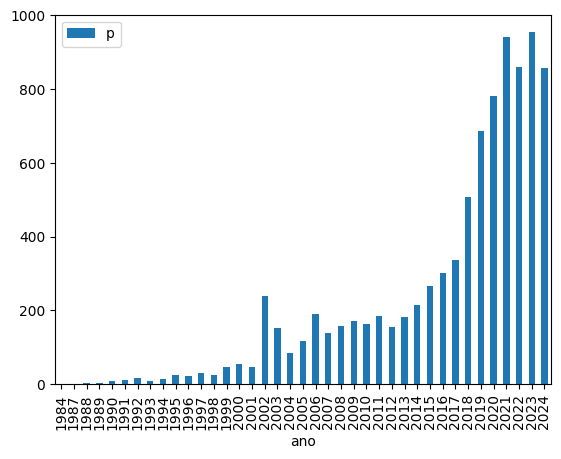

In [ ]:
df.plot.bar(x='publication_year')
plt.legend('publicações')
plt.xlabel('ano')

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_ciaam.authorships AS (
  SELECT w.work_id, wa.author_id, wa.institution_id, wa.author_order
  FROM projectdb_ciaam.ai_works AS w
  JOIN publicdb_openalex_2025_08_rm.works_authorships AS wa
  ON w.work_id = wa.work_id
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo

SELECT i.display_name AS institution, w.works
FROM (
  SELECT institution_id, COUNT(DISTINCT(work_id)) AS works
  FROM projectdb_ciaam.authorships
  GROUP BY institution_id
  #HAVING works >=100
  ORDER BY works DESC
  LIMIT 20
) AS w
JOIN publicdb_openalex_2025_08_rm.institutions AS i
ON w.institution_id = i.id
ORDER BY works DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'instituição')

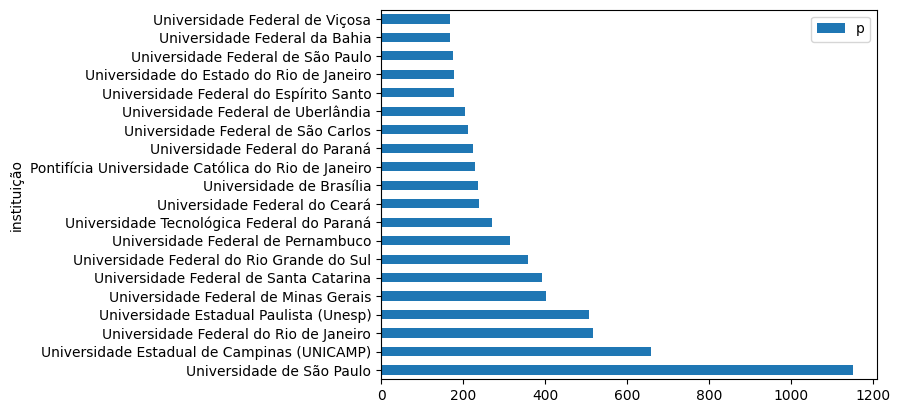

In [ ]:
df.plot.barh(x='institution')
plt.legend('publicações')
plt.ylabel('instituição')

In [ ]:
%%bigquery df --project=insyspo

SELECT a.display_name AS author, w.works
FROM (
  SELECT author_id, COUNT(DISTINCT(work_id)) AS works
  FROM projectdb_ciaam.authorships
  GROUP BY author_id
  #HAVING works >=100
  ORDER BY works DESC
  LIMIT 20
) AS w
JOIN publicdb_openalex_2025_08_rm.authors AS a
ON w.author_id = a.id
ORDER BY works DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery --project=insyspo

SELECT a.display_name AS author, w.works
FROM (
  SELECT author_id, COUNT(DISTINCT(work_id)) AS works
  FROM projectdb_ciaam.authorships
  GROUP BY author_id
  #HAVING works >=100
  ORDER BY works DESC
) AS w
JOIN publicdb_openalex_2025_08_rm.authors AS a
ON w.author_id = a.id
ORDER BY works DESC

Query is running:   0%|          |

Downloading:   0%|          |

,author,works
0,Teresa B. Ludermir,76
1,Ivo Barbi,60
2,Victor Hugo C. de Albuquerque,54
3,Leandro dos Santos Coelho,51
4,Cursino B. Jacobina,50
...,...,...
38916,Nicole Kleinstreuer,1
38917,A. Mastbaum,1
38918,Joiner dos Santos Sá,1
38919,Jugurta Lisboa Filho,1


Text(0, 0.5, 'autores')

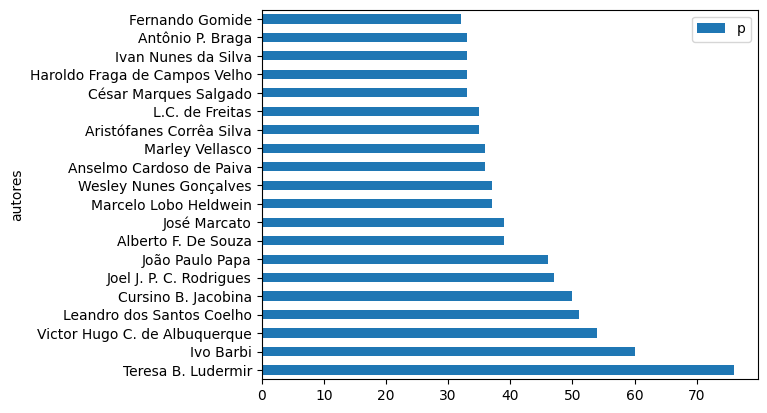

In [ ]:
df.plot.barh(x='author')
plt.legend('publicações')
plt.ylabel('autores')

In [ ]:
%%bigquery df --project=insyspo

SELECT a1.display_name AS author1,
 a2.display_name AS author2,
 w.works
FROM (
  SELECT a1.author_id AS aid1,
      a2.author_id AS aid2,
     COUNT(DISTINCT(a1.work_id)) AS works
  FROM projectdb_ciaam.authorships AS a1
  JOIN projectdb_ciaam.authorships AS a2
  ON a1.work_id = a2.work_id
  WHERE a1.author_id > a2.author_id
  GROUP BY a1.author_id, a2.author_id
) AS w
JOIN publicdb_openalex_2025_08_rm.authors AS a1
ON w.aid1 = a1.id
JOIN publicdb_openalex_2025_08_rm.authors AS a2
ON w.aid2 = a2.id
WHERE w.works>10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('authors_collab.csv',header = None,index=False)

In [ ]:
%%bigquery df --project=insyspo

SELECT a1.display_name AS institution1,
 a2.display_name AS institution2,
 w.works
FROM (
  SELECT a1.institution_id AS aid1,
      a2.institution_id AS aid2,
     COUNT(DISTINCT(a1.work_id)) AS works
  FROM projectdb_ciaam.authorships AS a1
  JOIN projectdb_ciaam.authorships AS a2
  ON a1.work_id = a2.work_id
  WHERE a1.institution_id > a2.institution_id
  GROUP BY a1.institution_id, a2.institution_id
) AS w
JOIN publicdb_openalex_2025_08_rm.institutions AS a1
ON w.aid1 = a1.id
JOIN publicdb_openalex_2025_08_rm.institutions AS a2
ON w.aid2 = a2.id
WHERE w.works>10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('institutions_collab.csv',header = None,index=False)

In [ ]:
%%bigquery --project=insyspo

SELECT a1.display_name_acronyms AS institution1,
 a2.display_name_acronyms AS institution2,
 w.works
FROM (
  SELECT a1.institution_id AS aid1,
      a2.institution_id AS aid2,
     COUNT(DISTINCT(a1.work_id)) AS works
  FROM projectdb_ciaam.authorships AS a1
  JOIN projectdb_ciaam.authorships AS a2
  ON a1.work_id = a2.work_id
  WHERE a1.institution_id > a2.institution_id
  GROUP BY a1.institution_id, a2.institution_id
) AS w
JOIN publicdb_openalex_2025_08_rm.institutions_display_name_acronyms AS a1
ON w.aid1 = a1.institution_id
JOIN publicdb_openalex_2025_08_rm.institutions_display_name_acronyms AS a2
ON w.aid2 = a2.institution_id
WHERE w.works>10

Query is running:   0%|          |

Downloading:   0%|          |

,institution1,institution2,works
0,UFRGS,UFSC,16
1,UFRGS,FURG,19
2,UNICAMP,UFSCar,11
3,UFSJ,UFMG,15
4,UNESP,USP,69
...,...,...,...
94,UNICAMP,UNIFESP,16
95,UW,UFMS,16
96,UNOESTE,UFMS,18
97,KUL,KI,15


In [ ]:
df.to_csv('institutions_collab_acro.csv',header = None,index=False)

In [ ]:
%%bigquery df --project=insyspo

SELECT a1.country_code AS country1,
 a2.country_code AS country2,
 w.works
FROM (
  SELECT a1.institution_id AS aid1,
      a2.institution_id AS aid2,
     COUNT(DISTINCT(a1.work_id)) AS works
  FROM projectdb_ciaam.authorships AS a1
  JOIN projectdb_ciaam.authorships AS a2
  ON a1.work_id = a2.work_id
  WHERE a1.institution_id > a2.institution_id
  GROUP BY a1.institution_id, a2.institution_id
) AS w
JOIN publicdb_openalex_2025_08_rm.institutions AS a1
ON w.aid1 = a1.id
JOIN publicdb_openalex_2025_08_rm.institutions AS a2
ON w.aid2 = a2.id
WHERE w.works>5 AND a1.country_code IS NOT NULL AND a2.country_code IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.to_csv('countries_collab.csv',header = None,index=False)

# Geographical information

In [ ]:
%%bigquery df --project=insyspo
SELECT a.*, b.latitude, b.longitude, b.city, b.country, b.country_code
FROM projectdb_ciaam.br_authors_insts_br_ai_works_wide AS a
JOIN publicdb_openalex_2025_08_rm.institutions AS b
ON a.institution_id = b.id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,author,author_id,institution,institution_id,works,IDLattes,latitude,longitude,city,country,country_code
0,Marcelo S. Reis,5079620580,Military Institute of Engineering,41870,1,'1622980448239879,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
1,Manuela Leal da Silva,5014182386,Military Institute of Engineering,41870,1,'3094446634314333,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
2,Wilian A. Cortopassi,5064010788,Military Institute of Engineering,41870,1,'9398939403951341,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
3,Reinaldo T. Delfino,5077863350,Military Institute of Engineering,41870,1,'5490885675521883,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
4,Alcino Palermo de Aguiar,5101456822,Military Institute of Engineering,41870,1,'6385098389900462,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
...,...,...,...,...,...,...,...,...,...,...,...
40219,Elucir Gir,5085651513,Universidade de São Paulo,17974374,128,'2381136403879304,-23.54750,-46.63611,São Paulo,Brazil,BR
40220,Francisco Inácio Bastos,5041147647,Fundação Oswaldo Cruz,52325,136,'6505487564442125,-22.90642,-43.18223,Rio de Janeiro,Brazil,BR
40221,Inês Dourado,5089008239,Universidade Federal da Bahia,126158947,142,'7845852622901449,-12.97563,-38.49096,Salvador,Brazil,BR
40222,Beatriz Grinsztejn,5024931884,Instituto Evandro Chagas,4210144600,191,'7121133812924668,-1.36556,-48.37222,Ananindeua,Brazil,BR


In [ ]:
%%bigquery df --project=insyspo
SELECT *
FROM (
  SELECT a.institution, a.institution_id,
    COUNT(DISTINCT(a.author_id)) AS researchers,
  FROM projectdb_ciaam.br_authors_insts_br_ai_works_wide AS a
  GROUP BY a.institution, a.institution_id
) AS a
JOIN (
  SELECT DISTINCT b.*
  FROM projectdb_ciaam.br_authors_insts_br_ai_works_wide AS a
  JOIN publicdb_openalex_2025_08_rm.institutions AS b
  ON a.institution_id = b.id
) AS b
ON a.institution_id = b.id
JOIN (
  SELECT institution_id, COUNT(DISTINCT(work_id)) AS works
  FROM projectdb_ciaam.authorships
  GROUP BY institution_id
  ORDER BY works DESC
) AS c
ON a.institution_id = c.institution_id



ERROR:
 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/insyspo/jobs?prettyPrint=false: Access Denied: Project insyspo: User does not have bigquery.jobs.create permission in project insyspo.

Location: None
Job ID: 669c9c6a-f53c-4447-bd6e-b6f59106d108



In [ ]:
df.head()

,institution,institution_id,researchers,id,image_thumbnail_url,homepage_url,type,ror,works_api_url,cited_by_count,...,updated,geo_country_code,country,city,latitude,longitude,geonames_city_id,region,institution_id_1,works
0,University of Havana,2656126,3,2656126,https://commons.wikimedia.org/w/index.php?titl...,http://www.uh.cu/,funder,https://ror.org/04204gr61,https://api.openalex.org/works?filter=institut...,152036,...,2025-08-17 11:22:46.958218,CU,Cuba,Havana,23.13302,-82.38304,3553478,None,2656126,2
1,Rafael Advanced Defense Systems (Israel),16362100,1,16362100,https://commons.wikimedia.org/w/index.php?titl...,http://www.rafael.co.il/,company,https://ror.org/016mey390,https://api.openalex.org/works?filter=institut...,66812,...,2025-08-20 10:15:45.397560,IL,Israel,Haifa,32.81841,34.98850,294801,None,16362100,1
2,Eduardo Mondlane University,16904388,2,16904388,https://commons.wikimedia.org/w/index.php?titl...,http://www.uem.mz/index.php,education,https://ror.org/05n8n9378,https://api.openalex.org/works?filter=institut...,122254,...,2025-08-19 09:37:51.624122,MZ,Mozambique,Maputo,-25.96553,32.58322,1040652,None,16904388,4
3,University College Cork,27577105,2,27577105,https://commons.wikimedia.org/w/index.php?titl...,https://www.ucc.ie,funder,https://ror.org/03265fv13,https://api.openalex.org/works?filter=institut...,1566938,...,2025-08-21 10:02:31.722050,IE,Ireland,Cork,51.89797,-8.47061,2965140,None,27577105,6
4,Budapest University of Technology and Economics,29770179,1,29770179,https://commons.wikimedia.org/w/index.php?titl...,https://www.bme.hu,funder,https://ror.org/02w42ss30,https://api.openalex.org/works?filter=institut...,540921,...,2025-08-20 20:53:21.531149,HU,Hungary,Budapest,47.49835,19.04045,3054643,None,29770179,1


In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

df = pd.read_csv('institutions_ai.csv')

# Define a map centered roughly in Latin America
latam_center = [ -15.0, -60.0 ]
m = folium.Map(location=latam_center, zoom_start=3, tiles='CartoDB positron')

# Add a cluster for better visualization when points overlap
marker_cluster = MarkerCluster().add_to(m)

# Add each institution as a marker
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"<b>{row['institution']}</b><br>{row['country']}"+'\nAutores: '+str(row['researchers'])+
          '\nTrabalhos: '+str(row['works'])+
          '\nTipo: '+str(row['type']), max_width=250),
        tooltip=row['institution'],
    ).add_to(marker_cluster)

# Display the map (in Jupyter Notebook or save as HTML)
m.save('latin_america_institutions.html')
m


# Mescla das três listas

Publicações
???

Pesquisadores
- IDLattes, Nome, volume publicações, proporção na produção, área L1, área L2, área L3, média citação normalizada, instituição mais recente
- mínimo 3 trabalhos na área (testar)
- agregação de sobreposição das listas

Instituições
- nomes, cidade, pesquisadores nesta lista, produção


# Visualização

- cor do nó pela quantidade
- nó com link para lista de pesquisadores pela ordem de produção
- buscador por nome para os nós da lista

para constar no relatório metodologico: 1.) natureza do dado: auto declarado; 2.) natureza das publicacoes consideradas: desprezou livro e capitulo de livro,



# Jacques Wainer - journals and conferences

In [ ]:
areas = ['machine learning']

# Lattes

In [ ]:
%%bigquery --project=insyspo

SELECT *
FROM `insyspo.projectdb_lattes_2025.total_TextosinicialfinalCV`
WHERE LOWER(ResumoCV) LIKE '%inteligência artificial%'
   OR LOWER(ResumoCV) LIKE 'machine learning'
   OR LOWER(ResumoCV) LIKE '%artificial intelligence%'
   OR LOWER(ResumoCV) LIKE '%aprendizado de máquina%'
   OR LOWER(ResumoCV) LIKE '%aprendizado profundo%'
   OR LOWER(ResumoCV) LIKE '%deep learning%'

Query is running:   0%|          |

Downloading:   0%|          |

,IDLattes,Nome,ResumoCV,Outrasinformacoesrelevantes
0,'4350529811601508,Katia Cristina Marcolino,Educadora e pesquisadora com ampla experiência...,"Coordenação de equipes de Suporte de Campo, H..."
1,'4350287546907783,Maria Eduarda Rocha Tavares,Estudante do sexto peródo de Nutrição - UNICEP...,Estudante de Nutrição na UNICEP- São Carlos. B...
2,'4348058537209224,Érick Machado Seolin,Graduado em Engenharia de Computação pela UNIC...,Participação no programa Ciência Sem Fronteira...
3,'4347139149624177,Marc Eric Barda Picavet,Atualmente pesquisador e pós-doc na Queensland...,https://orcid.org/0000-0001-6356-2869
4,'4345259703902540,Werciley Gonçalves da Silva,Mestre em Tecnologia da Informação e Comunicaç...,* Criador e Administrador do Portal de Ensino ...
...,...,...,...,...
28768,'5448622441685069,Matheus Henrique da Silva Amorim,Profissional na área de Ciência de Dados. Anal...,None
28769,'5448242503820544,André Luiz Gomes da Cruz Claudino,Doutor e Mestre em Física Computacional e Bach...,None
28770,'5447975999711027,Lucas Francisco Amaral Orosco Pellicer,Lucas Francisco Amaral Orosco Pellicer é atual...,None
28771,'5447477350232986,Rafael Vital Lacerda Alves,Superior Tecnólogo em Jogos Digitais pela Univ...,None


In [ ]:
%%bigquery --project=insyspo

SELECT IDLattes, COUNT(*) AS n
FROM `insyspo.projectdb_lattes_2025.total_Projetospesquisa`
WHERE LOWER(Descricao) LIKE '%inteligência artificial%'
   OR LOWER(Descricao) LIKE 'machine learning'
   OR LOWER(Descricao) LIKE '%artificial intelligence%'
   OR LOWER(Descricao) LIKE '%aprendizado de máquina%'
   OR LOWER(Descricao) LIKE '%aprendizado profundo%'
   OR LOWER(Descricao) LIKE '%deep learning%'
GROUP BY IDLattes
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

,IDLattes,n
0,'9674541381385819,20
1,'0506389215528790,11
2,'0286125884999207,11
3,'1244195230407619,11
4,'7396818382676736,10
...,...,...
15612,'3085926370264939,1
15613,'2937613050912699,1
15614,'2892902097769150,1
15615,'2892762571167069,1


In [ ]:
%%bigquery --project=insyspo

SELECT *
FROM (
  SELECT IDLattes, COUNT(*) AS n
  FROM `insyspo.projectdb_lattes_2025.total_Projetospesquisa`
  WHERE LOWER(Descricao) LIKE '%inteligência artificial%'
    OR LOWER(Descricao) LIKE 'machine learning'
    OR LOWER(Descricao) LIKE '%artificial intelligence%'
    OR LOWER(Descricao) LIKE '%aprendizado de máquina%'
    OR LOWER(Descricao) LIKE '%aprendizado profundo%'
    OR LOWER(Descricao) LIKE '%deep learning%'
  GROUP BY IDLattes
) AS a
JOIN projectdb_lattes_2025.total_Tabelaconsolidada AS b
ON a.IDLattes = b.IDLattes
ORDER BY n DESC
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

,IDLattes,n,IDLattes_1,Nome,AtualizacaoCV,Nascimento,Nacionalidade,NomeemCitacoes,Graduacao,Especializacao,...,ParticipacaoCongressos,tParticipacaoSeminarios,ParticipacaoSimposios,ParticipacaoOficinas,ParticipacaoEncontros,ParticipacaoFeiras,ParticipacaoExposicoes,ParticipacaoOlimpiadas,ParticipacaoOutroseventos,OrganizacaoEventos
0,'9674541381385819,20,'9674541381385819,André Carlos Ponce de Leon Ferreira de Carvalho,'16022025,Brasil,Brasil,"de Carvalho, A. C. P. L. F.;Carvalho, A.;André...",1,0,...,179,9,54,35,10,0,0,0,19,47
1,'0506389215528790,11,'0506389215528790,Aline Marins Paes Carvalho,'12022025,Brasil,Brasil,"PAES, A.;PAES, ALINE;Aline Paes",1,0,...,21,1,3,0,3,0,0,0,1,13
2,'1244195230407619,11,'1244195230407619,Cleber Zanchettin,'25022025,Brasil,Brasil,"ZANCHETTIN, C.;ZANCHETTIN, C;Zanchettin, Clebe...",1,0,...,23,3,7,0,2,0,0,0,1,75
3,'0286125884999207,11,'0286125884999207,Jair Minoro Abe,'21022025,Brasil,Brasil,"ABE, J.M.;ABE, JAIR M.;ABE, JAIR MINORO;Abe, J...",1,0,...,208,4,33,0,44,1,0,0,1,37
4,'8526960535874806,10,'8526960535874806,Solange Oliveira Rezende,'25022025,Brasil,Brasil,"REZENDE, S. O.;REZENDE, SOLANGE OLIVEIRA;REZEN...",1,0,...,23,6,30,0,5,1,0,0,31,11
5,'7396818382676736,10,'7396818382676736,Fernando Santos Osório,'30012025,Brasil,Brasil,"OSÓRIO, Fernando S.;OSORIO, FERNANDO S.;OSORIO...",1,0,...,55,12,23,11,18,3,2,0,2,27
6,'2171782600728348,9,'2171782600728348,Jefersson Alex dos Santos,'27012025,Brasil,Brasil,"Santos, J.A. dos;Santos, J.A.;SANTOS, Jefersso...",1,0,...,8,0,7,0,2,0,0,0,7,7
7,'2097340857065853,9,'2097340857065853,Estevam Rafael Hruschka Júnior,'11092022,Brasil,Brasil,"HRUSCHKA JR., ER;Hruschka, Estevam R.;HRUSCHKA...",1,0,...,34,1,5,0,5,0,0,0,0,10
8,'1531713258988427,9,'1531713258988427,Zhao Liang,'20022025,China,Brasil,"L. ZHAO;Zhao, L.;ZHAO, LIANG;LIANG, ZHAO",1,0,...,33,1,12,0,4,0,0,0,0,16
9,'9973021912226739,9,'9973021912226739,Adriano Alonso Veloso,'29112024,Brasil,Brasil,"VELOSO, A. A.;Veloso, Adriano;Veloso, A.;VELOS...",1,0,...,26,1,10,0,0,0,0,0,0,1


In [ ]:
- Expandir as palavras na busca do Lattes
- Redes de cooperação
  - Coautorias
  - Co-participação em projetos de pesquisa
  - Co-participação em temas?

- Desenho de mapas de rede filtrado por cada uma das entidades
- Visualização de mapa e de rede